In [1]:
!wget -nc https://lazyprogrammer.me/course_files/sp500_closefull.csv

File 'sp500_closefull.csv' already there; not retrieving.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [2]:
df0 = pd.read_csv('sp500_closefull.csv', index_col=0, parse_dates=True)
df0.dropna(axis=0, how='all', inplace=True)
df0.dropna(axis=1, how='any', inplace=True)

In [3]:
df_returns = pd.DataFrame()
for name in df0.columns:
  df_returns[name] = np.log(df0[name]).diff()

In [4]:
# split into train and test
Ntest = 1000
train_data = df_returns.iloc[:-Ntest]
test_data = df_returns.iloc[-Ntest:]

In [5]:
feats = ['AAPL', 'MSFT', 'AMZN']

In [6]:
class Env:
  def __init__(self, df):
    self.df = df
    self.n = len(df)
    self.current_idx = 0
    self.action_space = [0, 1, 2] # BUY, SELL, HOLD
    self.invested = 0

    self.states = self.df[feats].to_numpy()
    self.rewards = self.df['SPY'].to_numpy()

  def reset(self):
    self.current_idx = 0
    return self.states[self.current_idx]

  def step(self, action):
    # need to return (next_state, reward, done)

    self.current_idx += 1
    if self.current_idx >= self.n:
      raise Exception("Episode already done")

    if action == 0: # BUY
      self.invested = 1
    elif action == 1: # SELL
      self.invested = 0
    
    # compute reward
    if self.invested:
      reward = self.rewards[self.current_idx]
    else:
      reward = 0

    # state transition
    next_state = self.states[self.current_idx]

    done = (self.current_idx == self.n - 1)
    return next_state, reward, done

In [7]:
class StateMapper:
  def __init__(self, env, n_bins=6, n_samples=10000):
    # first, collect sample states from the environment
    states = []
    done = False
    s = env.reset()
    self.D = len(s) # number of elements we need to bin
    states.append(s)
    while True:
      a = np.random.choice(env.action_space)
      s2, _, done = env.step(a)
      states.append(s2)
      if len(states) >= n_samples:
        break
      if done:
        s = env.reset()
        states.append(s)
        if len(states) >= n_samples:
          break

    # convert to numpy array for easy indexing
    states = np.array(states)

    # create the bins for each dimension
    self.bins = []
    for d in range(self.D):
      column = np.sort(states[:,d])

      # find the boundaries for each bin
      current_bin = []
      for k in range(n_bins):
        boundary = column[int(n_samples / n_bins * (k + 0.5))]
        current_bin.append(boundary)

      self.bins.append(current_bin)


  def transform(self, state):
    x = np.zeros(self.D)
    for d in range(self.D):
      x[d] = int(np.digitize(state[d], self.bins[d]))
    return tuple(x)


  def all_possible_states(self):
    list_of_bins = []
    for d in range(self.D):
      list_of_bins.append(list(range(len(self.bins[d]) + 1)))
    # print(list_of_bins)
    return itertools.product(*list_of_bins)

In [8]:
class Agent:
  def __init__(self, action_size, state_mapper):
    self.action_size = action_size
    self.gamma = 0.8  # discount rate
    self.epsilon = 0.1
    self.learning_rate = 1e-1
    self.state_mapper = state_mapper

    # initialize Q-table randomly
    self.Q = {}
    for s in self.state_mapper.all_possible_states():
      s = tuple(s)
      for a in range(self.action_size):
        self.Q[(s,a)] = np.random.randn()

  def act(self, state):
    if np.random.rand() <= self.epsilon:
      return np.random.choice(self.action_size)

    s = self.state_mapper.transform(state)
    act_values = [self.Q[(s,a)] for a in range(self.action_size)]
    return np.argmax(act_values)  # returns action

  def train(self, state, action, reward, next_state, done):
    s = self.state_mapper.transform(state)
    s2 = self.state_mapper.transform(next_state)

    if done:
      target = reward
    else:
      act_values = [self.Q[(s2,a)] for a in range(self.action_size)]
      target = reward + self.gamma * np.amax(act_values)

    # Run one training step
    self.Q[(s,action)] += self.learning_rate * (target - self.Q[(s,action)])

In [9]:
def play_one_episode(agent, env, is_train):
  state = env.reset()
  done = False
  total_reward = 0

  while not done:
    action = agent.act(state)
    next_state, reward, done = env.step(action)
    total_reward += reward
    if is_train:
      agent.train(state, action, reward, next_state, done)
    state = next_state

  return total_reward

In [10]:
num_episodes = 500

In [11]:
train_data

,CSCO,UAL,TROW,ISRG,PRGO,TPR,DVN,MRO,BA,VRTX,...,M,CRM,PGR,WAT,BWA,LRCX,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,-0.004465,0.083163,0.011151,-0.004512,-0.039429,0.012045,0.001044,0.000934,0.032227,-0.033559,...,-0.011793,-0.004286,-0.003333,-0.013723,0.046560,-0.006793,-0.005939,0.029476,0.004308,-0.013019
2010-01-06,-0.006531,-0.047102,-0.015757,0.014405,-0.012713,0.019402,-0.003005,0.021850,0.029883,-0.017687,...,0.014134,-0.001746,-0.010067,0.001808,0.036075,-0.004555,0.017711,0.021889,-0.020832,0.002182
2010-01-07,0.004494,0.020881,-0.000739,-0.003759,-0.008127,0.000534,-0.005906,-0.006107,0.039684,-0.012690,...,0.022551,-0.004447,-0.013583,0.004260,0.013536,-0.001777,0.028207,-0.011911,0.010934,-0.009698
2010-01-08,0.005286,-0.016369,-0.003889,-0.005519,-0.005543,-0.005886,0.001973,0.001530,-0.009693,-0.020203,...,-0.033133,0.001485,0.009075,0.000817,-0.018454,0.024841,-0.003166,-0.002056,0.007014,-0.003149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-01-02,-0.007577,-0.008256,-0.001165,-0.006392,-0.003176,-0.006678,-0.004093,0.010898,-0.000231,0.035312,...,-0.000913,-0.001181,0.001851,0.010238,-0.003829,0.001385,-0.006057,-0.014987,-0.002324,0.000825
2015-01-05,-0.020121,-0.002868,-0.023239,-0.021541,-0.010376,-0.015668,-0.037778,-0.047620,-0.006950,-0.016715,...,-0.008562,-0.018227,-0.011157,-0.007580,-0.029289,-0.012284,-0.011690,-0.024057,-0.026215,-0.023373
2015-01-06,-0.000370,-0.024020,-0.017821,0.010482,-0.001882,-0.011776,-0.020655,-0.015149,-0.011848,-0.030792,...,-0.003692,-0.016816,-0.012418,-0.004345,-0.006984,-0.016833,-0.017523,-0.016677,-0.015662,-0.000282


In [11]:
train_env = Env(train_data)
test_env = Env(test_data)

In [12]:
action_size = len(train_env.action_space)
state_mapper = StateMapper(train_env)
agent = Agent(action_size, state_mapper)

In [13]:
train_rewards = np.empty(num_episodes)
test_rewards = np.empty(num_episodes)

In [14]:
for e in range(num_episodes):
  r = play_one_episode(agent, train_env, is_train=True)
  train_rewards[e] = r

  # test on the test set
  tmp_epsilon = agent.epsilon
  agent.epsilon = 0.
  tr = play_one_episode(agent, test_env, is_train=False)
  agent.epsilon = tmp_epsilon
  test_rewards[e] = tr

  print(f"eps: {e + 1}/{num_episodes}, train: {r:.5f}, test: {tr:.5f}")

eps: 1/500, train: 0.26808, test: 0.42732
eps: 2/500, train: 0.33557, test: 0.39358
eps: 3/500, train: 0.34344, test: 0.39201
eps: 4/500, train: 0.11913, test: 0.40293
eps: 5/500, train: 0.37486, test: 0.26249
eps: 6/500, train: 0.12037, test: 0.39895
eps: 7/500, train: 0.44644, test: 0.44825
eps: 8/500, train: 0.04960, test: 0.38973
eps: 9/500, train: 0.11723, test: 0.31086
eps: 10/500, train: 0.13604, test: 0.28827
eps: 11/500, train: 0.25118, test: 0.30410
eps: 12/500, train: 0.11672, test: 0.27340
eps: 13/500, train: 0.30602, test: 0.30769
eps: 14/500, train: 0.40103, test: 0.21766
eps: 15/500, train: 0.23569, test: 0.36583
eps: 16/500, train: 0.04625, test: 0.23040
eps: 17/500, train: 0.22488, test: 0.30410
eps: 18/500, train: 0.43058, test: 0.32250
eps: 19/500, train: 0.47989, test: 0.29094
eps: 20/500, train: 0.39182, test: 0.21093
eps: 21/500, train: 0.13843, test: 0.31072
eps: 22/500, train: 0.07358, test: 0.28410
eps: 23/500, train: 0.21679, test: 0.25067
eps: 24/500, train: 

eps: 192/500, train: 1.42336, test: 0.29666
eps: 193/500, train: 1.35937, test: 0.17809
eps: 194/500, train: 1.43042, test: 0.24605
eps: 195/500, train: 1.48869, test: 0.21185
eps: 196/500, train: 1.27698, test: 0.17726
eps: 197/500, train: 1.54331, test: 0.16273
eps: 198/500, train: 1.42598, test: 0.25066
eps: 199/500, train: 1.29769, test: 0.25877
eps: 200/500, train: 1.17737, test: 0.14700
eps: 201/500, train: 1.36394, test: 0.22395
eps: 202/500, train: 1.37318, test: 0.24106
eps: 203/500, train: 1.44068, test: 0.18587
eps: 204/500, train: 1.21253, test: 0.15382
eps: 205/500, train: 1.31495, test: 0.16732
eps: 206/500, train: 1.24383, test: 0.13328
eps: 207/500, train: 1.54463, test: 0.07870
eps: 208/500, train: 1.26196, test: 0.26178
eps: 209/500, train: 1.45152, test: 0.16907
eps: 210/500, train: 1.21079, test: 0.26051
eps: 211/500, train: 1.35766, test: 0.24456
eps: 212/500, train: 1.24853, test: 0.29891
eps: 213/500, train: 1.28667, test: 0.27564
eps: 214/500, train: 1.29601, te

eps: 379/500, train: 1.61855, test: 0.38379
eps: 380/500, train: 1.54529, test: 0.41674
eps: 381/500, train: 1.55897, test: 0.41762
eps: 382/500, train: 1.67805, test: 0.38933
eps: 383/500, train: 1.78485, test: 0.41681
eps: 384/500, train: 1.64506, test: 0.39828
eps: 385/500, train: 1.65987, test: 0.44674
eps: 386/500, train: 1.64085, test: 0.47183
eps: 387/500, train: 1.68553, test: 0.43342
eps: 388/500, train: 1.62744, test: 0.44953
eps: 389/500, train: 1.62066, test: 0.45886
eps: 390/500, train: 1.65207, test: 0.38378
eps: 391/500, train: 1.60966, test: 0.44155
eps: 392/500, train: 1.40360, test: 0.41048
eps: 393/500, train: 1.48854, test: 0.39710
eps: 394/500, train: 1.66412, test: 0.41409
eps: 395/500, train: 1.53127, test: 0.47314
eps: 396/500, train: 1.50584, test: 0.45255
eps: 397/500, train: 1.64169, test: 0.37114
eps: 398/500, train: 1.56835, test: 0.34343
eps: 399/500, train: 1.51215, test: 0.38897
eps: 400/500, train: 1.65949, test: 0.35532
eps: 401/500, train: 1.59127, te

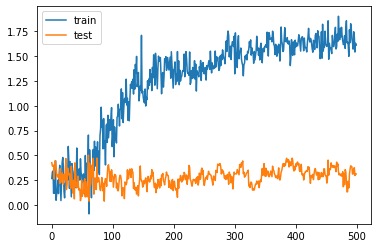

In [16]:
plt.plot(train_rewards, label='train')
plt.plot(test_rewards, label='test')
plt.legend();

In [21]:
test_rewards[0:10].mean()

0.3714385242650531